In [1]:
%reload_ext autoreload
%autoreload 2

# import all the functions from the fastfeedback module
from fastfeedback import *

Welcome to JupyROOT 6.26/06


In [2]:
#Loading the CAFs data

data_manager = DataManager("/pnfs/dune/persistent/users/pgranger/atmospherics-data/atmospherics_prod_1M_events_cafs_hadd_with_weights.root")

Loading data...
Finished loading data


# I. Using the current reconstruction performance

In [3]:
#Preparing the data with the default settings, of the current reco performances
data = data_manager.prepare_data()

#Defining the binning for the true and reco energy and coszenith
Ebins = np.logspace(-1, 1, 200)
Czbins = np.linspace(-1, 1, 100)
Ebins_reco = np.logspace(-1, 1, 50)
Czbins_reco = np.linspace(-1, 1, 20)

#Creating the events distribution
events = EventDistrib(data, Ebins, Czbins, Ebins_reco, Czbins_reco)

Filling histograms...
Using the following detected output channels: ['NC', 'NuE', 'NuMu']
Finished filling histograms...


In [4]:
from tqdm import tqdm

#Gets the standard oscillation parameters
pars = get_nufit(MH.Normal)
#Compute the events with the standard oscillation parameters
events.compute_osc(pars)
#Saving the reference event rates
ref_event_rates = {fl: events.detected_events(fl) for fl in events.detected_channels}

LnL_values = {fl: [] for fl in events.detected_channels}

#Sampling dcp values
sampling = np.linspace(0, 2*np.pi, 50)
for val in tqdm(sampling):
    #Setting the dcp value
    pars.dcp = val
    #Computing the events with the new dcp value
    events.compute_osc(pars)
    #Saving the expected event rates
    expected = {fl: events.detected_events(fl) for fl in events.detected_channels}

    #Computing the LnL values
    for ch in events.detected_channels:
        LnL_values[ch].append(LnL(ref_event_rates[ch], expected[ch]))

#Converting the lists to numpy arrays
LnL_values = {fl: np.array(values) for fl, values in LnL_values.items()}

100%|██████████| 50/50 [00:39<00:00,  1.27it/s]


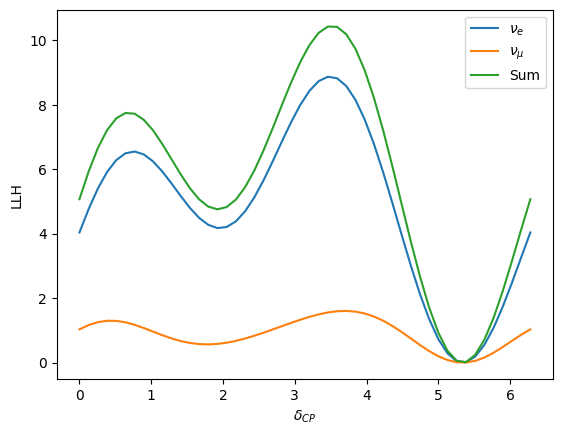

In [6]:
latex_names = {
    Flavor.NuE: r"$\nu_e$",
    Flavor.NuMu: r"$\nu_\mu$",
    Flavor.NuMuBar: r"$\bar{\nu}_\mu$",
    Flavor.NuEBar: r"$\bar{\nu}_e$",
    Flavor.NuTau: r"$\bar{\nu}_\tau$",
    Flavor.NuTauBar: r"$\bar{\nu}_\tau$",
}


plt.figure()
sum = 0
for ch, values in LnL_values.items():
    if ch == Flavor.NC:
        continue
    sum += values
    plt.plot(sampling, values, label=latex_names[ch])
plt.plot(sampling, sum, label="Sum")
plt.xlabel(r'$\delta_{CP}$')
plt.ylabel('LLH')
plt.legend()

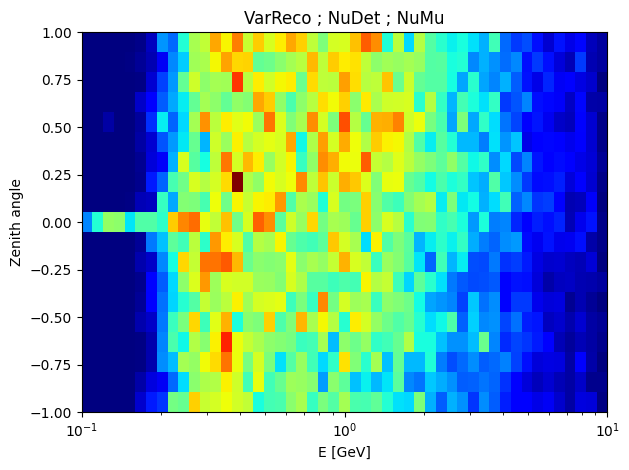

In [7]:
#Plotting some event distributions
pars = get_nufit(MH.Normal)
events.compute_osc(pars)
fig = events.plot_distrib(VarType.VarReco, NuAxis.NuDet, Flavor.NuMu, oscillated=True)

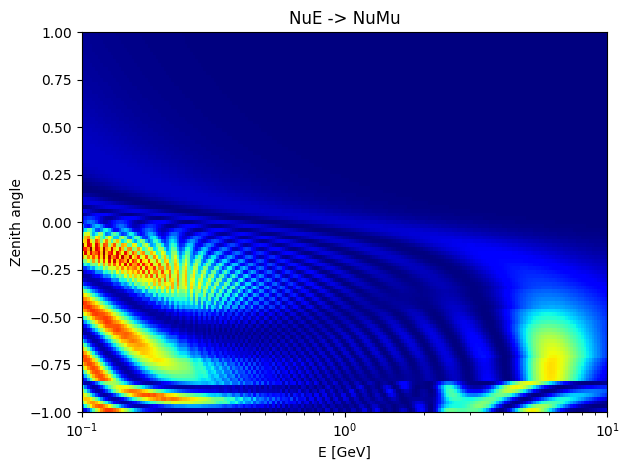

In [12]:
#Plotting some oscillograms
fig = events.get_oscillogram(Flavor.NuE, Flavor.NuMu)

# II. Tweaking some resolutions by hand

### What happens to the dCP sensitivity if we can make some nu/nubar separation?

In [8]:
data_manager.set_direc_reco(Method.Reco)
data_manager.set_energy_reco(Method.Reco)
data_manager.set_flavor_discrimination(Method.Reco)

efficiencies = {
    Flavor.NuE: 1,
    Flavor.NuEBar: 1,
    Flavor.NuMu: 1,
    Flavor.NuMuBar: 1,
}
nunubar = FakeEfficiency(efficiencies)
data_manager.set_nunubar_discrimination(Method.Efficiency, nunubar)
data = data_manager.prepare_data()
events = EventDistrib(data, Ebins, Czbins, Ebins_reco, Czbins_reco)

Filling histograms...
Using the following detected output channels: ['NuMuBar', 'NuEBar', 'NC', 'NuE', 'NuMu']
Finished filling histograms...


100%|██████████| 50/50 [00:39<00:00,  1.28it/s]


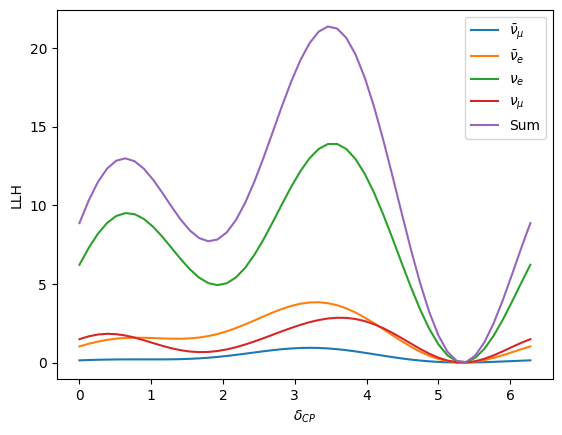

In [10]:
#Updated sensitivity

#Gets the standard oscillation parameters
pars = get_nufit(MH.Normal)
#Compute the events with the standard oscillation parameters
events.compute_osc(pars)
#Saving the reference event rates
ref_event_rates = {fl: events.detected_events(fl) for fl in events.detected_channels}

LnL_values = {fl: [] for fl in events.detected_channels}

#Sampling dcp values
sampling = np.linspace(0, 2*np.pi, 50)
for val in tqdm(sampling):
    #Setting the dcp value
    pars.dcp = val
    #Computing the events with the new dcp value
    events.compute_osc(pars)
    #Saving the expected event rates
    expected = {fl: events.detected_events(fl) for fl in events.detected_channels}

    #Computing the LnL values
    for ch in events.detected_channels:
        LnL_values[ch].append(LnL(ref_event_rates[ch], expected[ch]))

#Converting the lists to numpy arrays
LnL_values = {fl: np.array(values) for fl, values in LnL_values.items()}

plt.figure()
sum = 0
for ch, values in LnL_values.items():
    if ch == Flavor.NC:
        continue
    sum += values
    plt.plot(sampling, values, label=latex_names[ch])
plt.plot(sampling, sum, label="Sum")
plt.xlabel(r'$\delta_{CP}$')
plt.ylabel('LLH')
plt.legend()

**We can see some sensitivity improvement**

In [ ]:
data_manager.set_direc_reco(Method.Reco)
data_manager.set_energy_reco(Method.Reco)
data_manager.set_flavor_discrimination(Method.Reco)
data_manager.set_nunubar_discrimination(Method.Reco)

#Adding some fake resolution for the energy (can also be done for the direction)
Ebins_fake = np.logspace(-1, 1, 100)
Eres = np.ones(len(Ebins_fake)+1)*0.1
Efake = FakeResolution(Ebins_fake, Eres, pl.col('Ev'))
data_manager.set_energy_reco(Method.Efficiency, Efake)

data = data_manager.prepare_data()
events = EventDistrib(data, Ebins, Czbins, Ebins_reco, Czbins_reco)

#To be continued...